In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier



from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer

from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
data = pd.read_csv("hotel_bookings.csv") 
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
data["is_canceled"].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [5]:
corr_matrix = data.corr()
corr_matrix["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.293123
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
children                          0.005048
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
company                          -0.020642
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
agent                            -0.083114
is_repeated_guest                -0.084793
booking_changes                  -0.144381
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64

In [6]:
nulls = data.isnull().sum()
nulls[nulls > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [7]:
data.iloc[:,23].fillna(data.iloc[:,23].mean(), inplace=True)
data.iloc[:,10].fillna(data.iloc[:,10].mean(), inplace=True)

In [8]:
nulls = data.isnull().sum()
nulls[nulls > 0]


country       488
company    112593
dtype: int64

In [9]:
data = data.drop(['stays_in_weekend_nights','arrival_date_day_of_month', 'children', 'arrival_date_week_number', 'company', 'reservation_status_date'], axis=1)

In [10]:
data["country"].value_counts()

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
PYF        1
GUY        1
MLI        1
NCL        1
BFA        1
Name: country, Length: 177, dtype: int64

In [11]:
print("Data shape BEFORE drop of rows where country is not especified : ",data.shape)
data = data[data['country'].notna()]
print("Data shape AFTER drop of rows where country is not especified : ",data.shape)

Data shape BEFORE drop of rows where country is not especified :  (119390, 26)
Data shape AFTER drop of rows where country is not especified :  (118902, 26)


In [12]:
data["country"].value_counts()

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
PYF        1
GUY        1
MLI        1
NCL        1
BFA        1
Name: country, Length: 177, dtype: int64

In [13]:
data = data.drop(['country'], axis=1)
# as it contains a lot of variety

In [14]:
data = data.drop(['reservation_status'], axis=1)

In [15]:
X = (data.loc[:, data.columns != 'is_canceled'])
y = (data.loc[:, data.columns == 'is_canceled'])

In [16]:
x_columns = X.columns

In [17]:
object_column_name = X.select_dtypes('object').columns
print (object_column_name)

object_column_index = X.columns.get_indexer(X.select_dtypes('object').columns)
print (object_column_index)

Index(['hotel', 'arrival_date_month', 'meal', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type'],
      dtype='object')
[ 0  3  7  8  9 13 14 16 19]


In [18]:
print(X.shape)

columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), object_column_index)], remainder='passthrough')

X = columnTransformer.fit_transform(X)
print(X.shape)

(118902, 23)
(118902, 75)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 25)


In [20]:
def model(algo):
    algo_model = algo.fit(X_train, y_train)
    global y_prob, y_pred
    y_prob = algo.predict_proba(X_test)[:,1]
    y_pred = algo_model.predict(X_test)

    print('Accuracy Score: {}\n\nConfusion Matrix:\n {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred),roc_auc_score(y_test,y_pred)))

In [21]:
def model(algorithm, X_train, X_test, y_train, y_test):
    alg = algorithm
    alg_model = alg.fit(X_train, y_train)
    global y_prob, y_pred
    y_prob = alg.predict_proba(X_test)[:,1]
    y_pred = alg_model.predict(X_test)

    print('Accuracy Score: {}\n\nConfusion Matrix:\n {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred)))
    

def ROC(y_test, y_prob):
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [22]:
print('Model: Logistic Regression\n')
model(LogisticRegression(solver = "liblinear"), X_train, X_test, y_train, y_test)

Model: Logistic Regression

Accuracy Score: 0.808191528132096

Confusion Matrix:
 [[20787  1615]
 [ 5227  8042]]


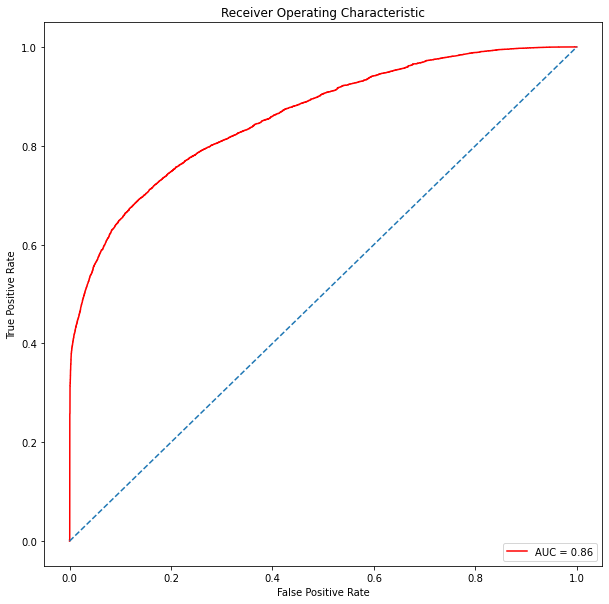

In [23]:
ROC(y_test, y_prob)

In [24]:
print('Model: Decision Tree\n')
model(DecisionTreeClassifier(max_depth = 12), X_train, X_test, y_train, y_test)

Model: Decision Tree

Accuracy Score: 0.8246474727369572

Confusion Matrix:
 [[20815  1587]
 [ 4668  8601]]


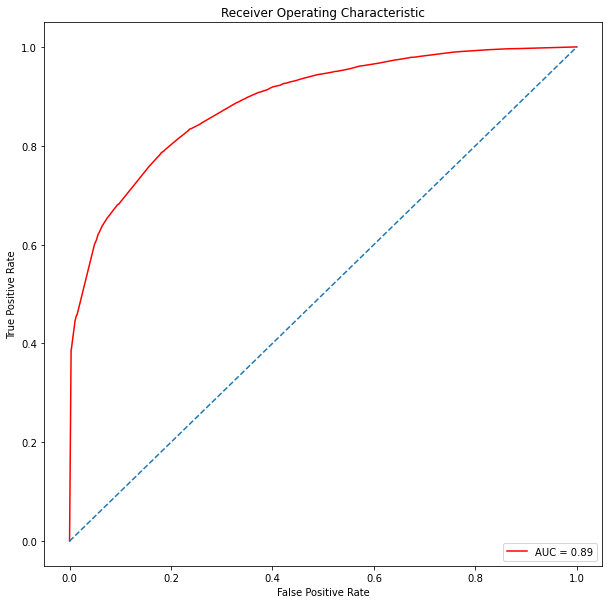

In [25]:
ROC(y_test, y_prob)

In [26]:
print('Model: Random Forest\n')
model(RandomForestClassifier(), X_train, X_test, y_train, y_test)


Model: Random Forest

Accuracy Score: 0.8675674918000617

Confusion Matrix:
 [[20814  1588]
 [ 3136 10133]]


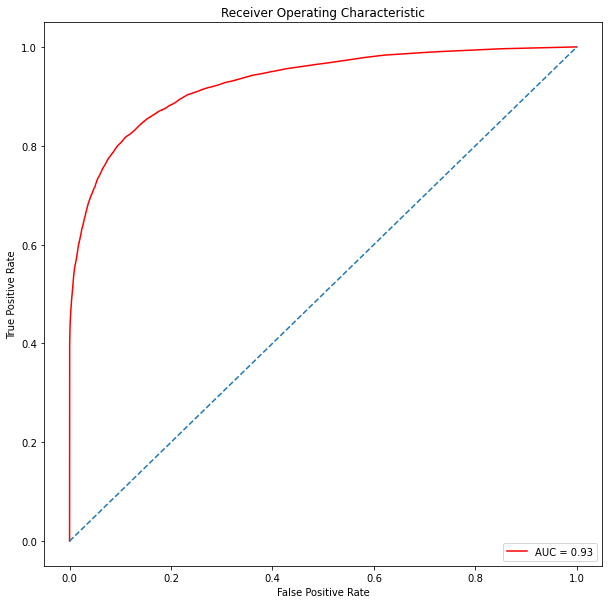

In [27]:
ROC(y_test, y_prob)

In [28]:
print('Model: Gaussian Naive Bayes\n')
model(GaussianNB(), X_train, X_test, y_train, y_test)

Model: Gaussian Naive Bayes

Accuracy Score: 0.6036556306243167

Confusion Matrix:
 [[10703 11699]
 [ 2439 10830]]


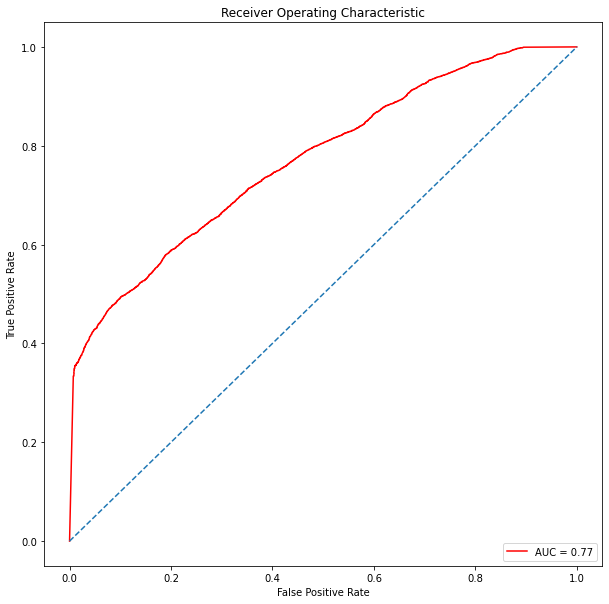

In [29]:
ROC(y_test, y_prob)

In [30]:
randomf = RandomForestClassifier()
rf_model1 = randomf.fit(X_train, y_train)

pd.DataFrame(data = rf_model1.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False)[:15].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")

AttributeError: 'numpy.ndarray' object has no attribute 'columns'